In [13]:
# !pip install pandas

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

print("complete")

complete


In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

train_path = r"/home/sfmt/Downloads/6483/datasets/datasets/train"
val_path = r"/home/sfmt/Downloads/6483/datasets/datasets/val"

full_train_dataset = datasets.ImageFolder(train_path, data_transforms['train'])
full_val_dataset = datasets.ImageFolder(val_path, data_transforms['val'])

np.random.seed(42)
train_indices = np.random.choice(len(full_train_dataset), 2000, replace=False)
val_indices = np.random.choice(len(full_val_dataset), 500, replace=False)

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_val_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Training Set: {len(train_dataset)}")
print(f"Validation Set: {len(val_dataset)}")
print(f"Device: {device}")
print("complete")

Training Set: 2000
Validation Set: 500
Device: cuda
complete


In [20]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Using Sigmoid to classify
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

model = model.to(device)
print("complete")

/home/sfmt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sfmt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


complete


In [21]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
print("complete")

complete


Epoch 1/30.. Train Loss: 0.4624.. Val Loss: 0.2385
Epoch 2/30.. Train Loss: 0.2870.. Val Loss: 0.1233
Epoch 3/30.. Train Loss: 0.2546.. Val Loss: 0.1270
Epoch 4/30.. Train Loss: 0.2190.. Val Loss: 0.0850
Epoch 5/30.. Train Loss: 0.2127.. Val Loss: 0.0879
Epoch 6/30.. Train Loss: 0.2096.. Val Loss: 0.0725
Epoch 7/30.. Train Loss: 0.1992.. Val Loss: 0.0763
Epoch 8/30.. Train Loss: 0.1803.. Val Loss: 0.0654
Epoch 9/30.. Train Loss: 0.1963.. Val Loss: 0.0642
Epoch 10/30.. Train Loss: 0.1781.. Val Loss: 0.0599
Epoch 11/30.. Train Loss: 0.1865.. Val Loss: 0.0739
Epoch 12/30.. Train Loss: 0.1758.. Val Loss: 0.0636
Epoch 13/30.. Train Loss: 0.1885.. Val Loss: 0.0576
Epoch 14/30.. Train Loss: 0.1940.. Val Loss: 0.0645
Epoch 15/30.. Train Loss: 0.1627.. Val Loss: 0.0594
Epoch 16/30.. Train Loss: 0.1784.. Val Loss: 0.0629
Early stopping!


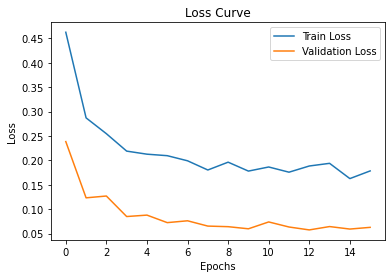

complete


In [22]:
epochs = 30
patience = 3
best_loss = np.inf
counter = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch+1}/{epochs}.. Train Loss: {epoch_loss:.4f}.. Val Loss: {epoch_val_loss:.4f}')

    # EarlyStopping
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()
print("complete")

In [23]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dir = r"/home/sfmt/Downloads/6483/datasets/datasets/test"
test_images = sorted(os.listdir(test_dir), key=lambda x: int(''.join(filter(str.isdigit, x)) or -1))

results = []
with torch.no_grad():
    for idx, img_name in enumerate(test_images, start=1):
        img_path = os.path.join(test_dir, img_name)
        img = datasets.folder.default_loader(img_path)
        img = test_transforms(img).unsqueeze(0).to(device)

        output = model(img)
        label = 1 if output.item() > 0.5 else 0
        results.append([idx, label])

submission = pd.DataFrame(results, columns=['id', 'label'])
submission.to_csv('submission.csv', index=False)

print("submission.csv")

submission.csv
